In [2]:
%matplotlib inline


Reinforcement Learning (DQN)
=====================================


Cart-Pole
----------
** Цель ** - удержать шест в вертикальном положении. Агент воздействует на среду двумя действиями:
* движение влево
* движение вправо

Агент наблюдает текущее стсояние среды и выбирает действие, после чего среда переходит в новое состяние, и возвражвет награду. В этом примере игра заканчивается, если шест упал слишком сильно

В задаче среда поставляет агенту четыре числа:
* позиция
* скорость
* угол ....

С точки зрения же DQN мы решаем эту задачу через взгляд на скрин, который и является состоянием.




In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
print("Is python : {}".format(is_ipython))

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

Is python : True
Device : cuda


## Replay Memory


Мы используем "experience replay memory" для тренировки нашей сети. 
В нее мы сохраняем все переходы, которые делает агент для последующей тренировки сети. Основная цель - это декорреляция примеров в батчах.


In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Положить переход в память."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """ Получить сэмпл из памяти """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

DQN алгоритм
-------------

Наша цель найти такую политику, которая пытается максимизировать дисконтированную кумулятивную награду
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 
$R_{t_0}$ - ответ среды. The discount,
$\gamma$, постоянное числов диапазоне от $0$ до $1$, что бы сумма сходилась. 
Такая награда говорит, что чем дальше в будущее мы заглядываем тем менее оно для нас ценно.

Идея Q-learning - мы имеем функцию оценки ценности действия 
$Q^*: State \times Action \rightarrow \mathbb{R}$, которая говорит нам какая награда будет если мы выберем действие в текущем состоянии. Таким образом, мы можем сконструйировать политику, которая максимизирует нашу награду:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

Мы не имеем прямого доступа к  $Q^*$, но мы можем сделать апроксимацию нашей функции при помощи нейросети и получить нашу 
$Q^*$.

Во время тренировки мы используем тот факт, что функция $Q$
для политики соответсвует уравнению Беллмана:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

Разница между правой и левой частью уравнения - это ошибка временной разницы $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

Для минимизации используем [Функция потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss). 
Функция действует как MSE если ошибка небольшая и L1 если ошибка большая. Это позволяет сделать функцию потерь усточивой к выбросам, так как оцениваемая $Q$ слишком зашумленная. Мы считаем ошибку по батчам $B$, которые сэмплируются из replay memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{для } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{иначе.}
   \end{cases}\end{align}

### Q-network

Модель - это конволюционная сеть, которая получает на вход разницу между текущим и предыдущим патчем скрина. Сеть имеет два выхода, которые представляют  $Q(s, \mathrm{лево})$ и $Q(s, \mathrm{право})$ (где $s$ вход сети). Сеть пытается предсказать ценность действия, которое опреднеляется текущим входом.



In [6]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.conv2(x))
        x = F.relu(self.bn3(self.conv3(x)))
        #x = F.relu(self.conv3(x))
        return self.head(x.view(x.size(0), -1))

### Вход


Вытаскиваем картинку из среды. Используем бонусы из ``torchvision``



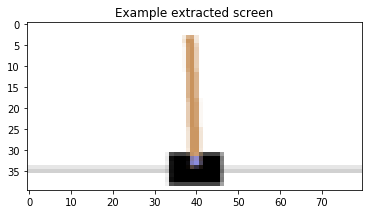

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # транспонирование в порядок торча (СHW)
    # Убираем верх и низ экрана
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Убираем края экрана, чтобы получить картинку с центрированной тележкой
    screen = screen[:, :, slice_range]
    # Конвертируем в торч тензор
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Ресайзим и добавляем батч размерность
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

Training
--------

#### Гиперпараметры и утилиты


-  ``select_action`` - выбор действия согласно $\epsilon$ - жадной политике. Сэмплируем равномерно. Начальное значение вероятности задается ``EPS_START`` и уменьшается экспоненциально до ``EPS_END``. ``EPS_DECAY`` - задает клэффициент убывания
-  ``plot_durations`` - строит график продолжительности эпизодов, и среднее по 100 последним эпизодам.


In [116]:
BATCH_SIZE = 1024
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE=10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        #print("Return by policy")
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        #print("Return random")
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    #plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())

### Тренировка модели


Выбирает батчи, склеиваем тензора в один пакет, считаем $Q(s_t, a_t)$ и
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, и используем их в лоссе. Устанавливаем $V(s) = 0$ if $s$ если узел терминальный. Так же мы используем target_network для вычисления $V(s_{t+1})$ для получения более стабильных оценок, поскольку веса сети target - заморожены, и изредка обновляются.



In [117]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

#### Тренируем модель


Complete


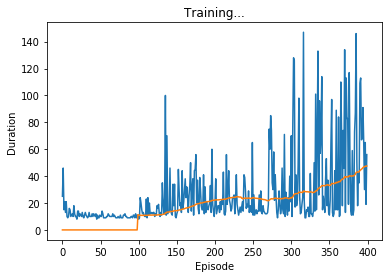

In [119]:
num_episodes = 200
for i_episode in range(num_episodes):
    # Инициализация среды
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        # Выбрать и выполнить нове действие
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Получаем новое состояние
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Сохраняем состояние, следующее состояние, награду и действие в память
        memory.push(state, action, next_state, reward)

        # Переходим в новое состояние
        state = next_state

        # Шаг оптимизации 
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
#plt.ioff()
plt.show()

In [8]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
#print(type(state))
for i in range(1000):
    # Выбрать и выполнить нове действие
    action = select_action(state)
    _,_,done,_ = env.step(action.item())
    
    # Получаем новое состояние
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None
        break
    state = next_state
    show_state(env, i)

NameError: name 'select_action' is not defined